# Convert a PaddlePaddle Model to OpenVINO™ IR

This notebook shows how to convert a MobileNetV3 model from [PaddleHub](https://github.com/PaddlePaddle/PaddleHub), pre-trained on the [ImageNet](https://www.image-net.org) dataset, to OpenVINO IR. It also shows how to perform classification inference on a sample image, using [OpenVINO Runtime](https://docs.openvino.ai/2024/openvino-workflow/running-inference.html) and compares the results of the [PaddlePaddle](https://github.com/PaddlePaddle/Paddle) model with the IR model.

Source of the [model](https://www.paddlepaddle.org.cn/hubdetail?name=mobilenet_v3_large_imagenet_ssld&en_category=ImageClassification).


#### Table of contents:

- [Preparation](#Preparation)
    - [Imports](#Imports)
    - [Settings](#Settings)
- [Show Inference on PaddlePaddle Model](#Show-Inference-on-PaddlePaddle-Model)
- [Convert the Model to OpenVINO IR Format](#Convert-the-Model-to-OpenVINO-IR-Format)
- [Select inference device](#Select-inference-device)
- [Show Inference on OpenVINO Model](#Show-Inference-on-OpenVINO-Model)
- [Timing and Comparison](#Timing-and-Comparison)
- [Select inference device](#Select-inference-device)
- [References](#References)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/paddle-to-openvino/paddle-to-openvino-classification.ipynb" />


## Preparation
[back to top ⬆️](#Table-of-contents:)

### Imports
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "paddlepaddle>=2.5.1,<2.6.0"
%pip install -q "paddleclas>=2.5.2" --no-deps
%pip install -q "prettytable" "ujson" "visualdl>=2.5.3" "faiss-cpu>=1.7.1" Pillow tqdm "matplotlib>=3.4" "opencv-python" "scikit-learn"
# Install openvino package
%pip install -q "openvino>=2023.1.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleclas 2.6.0 requires gast==0.3.3, but you have gast 0.6.0 which is incompatible.
paddleclas 2.6.0 requires numpy==1.24.4, but you have numpy 1.26.4 which is incompatible.
paddleclas 2.6.0 re

In [2]:
import time
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from paddleclas import PaddleClas
from PIL import Image

# Fetch `notebook_utils` module
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("paddle-to-openvino-classification.ipynb")

<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


### Settings
[back to top ⬆️](#Table-of-contents:)

Set `IMAGE_FILENAME` to the filename of an image to use. Set `MODEL_NAME` to the PaddlePaddle model to download from PaddleHub. `MODEL_NAME` will also be the base name for the IR model. The notebook is tested with the [MobileNetV3_large_x1_0](https://github.com/PaddlePaddle/PaddleClas/blob/release/2.5/docs/en/models/Mobile_en.md) model. Other models may use different preprocessing methods and therefore require some modification to get the same results on the original and converted model.

First of all, we need to download and unpack model files.
The first time you run this notebook, the PaddlePaddle model is downloaded from PaddleHub. This may take a while.

In [3]:
# Download the image from the openvino_notebooks storage
img = Path("data/coco_close.png")

if not img.exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_close.png",
        directory="data",
    )

IMAGE_FILENAME = img.as_posix()

MODEL_NAME = "MobileNetV3_large_x1_0"
MODEL_DIR = Path("model")
if not MODEL_DIR.exists():
    MODEL_DIR.mkdir()

if not (MODEL_DIR / "{}_infer".format(MODEL_NAME)).exists():
    MODEL_URL = "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/inference/{}_infer.tar".format(MODEL_NAME)
    download_file(MODEL_URL, directory=MODEL_DIR)
    file = tarfile.open(MODEL_DIR / "{}_infer.tar".format(MODEL_NAME))
    res = file.extractall(MODEL_DIR)
    if not res:
        print(f'Model Extracted to "./{MODEL_DIR}".')
    else:
        print("Error Extracting the model. Please check the network.")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


coco_close.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

MobileNetV3_large_x1_0_infer.tar:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

Model Extracted to "./model".


## Show Inference on PaddlePaddle Model
[back to top ⬆️](#Table-of-contents:)

In the next cell, we load the model, load and display an image, do inference on that image, and then show the top three prediction results.

[2025/02/13 05:14:14] ppcls WARNING: The current running environment does not support the use of GPU. CPU has been used instead.


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


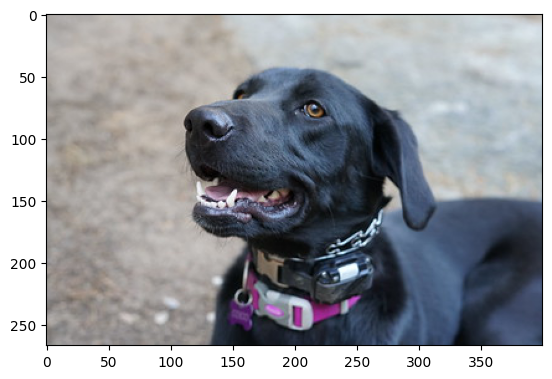

In [4]:
classifier = PaddleClas(inference_model_dir=MODEL_DIR / "{}_infer".format(MODEL_NAME))
result = next(classifier.predict(IMAGE_FILENAME))
class_names = result[0]["label_names"]
scores = result[0]["scores"]
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")

`classifier.predict()` takes an image file name, reads the image, preprocesses the input, then returns the class labels and scores of the image. Preprocessing the image is done behind the scenes. The classification model returns an array with floating point values for each of the 1000 ImageNet classes. The higher the value, the more confident the network is that the class number corresponding to that value (the index of that value in the network output array) is the class number for the image.

To see PaddlePaddle's implementation for the classification function and for loading and preprocessing data, uncomment the next two cells.

In [5]:
# classifier??

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# classifier.get_config()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The `classifier.get_config()` module shows the preprocessing configuration for the model. It should show that images are normalized, resized and cropped, and that the BGR image is converted to RGB before propagating it through the network. In the next cell, we get the `classifier.predictror.preprocess_ops` property that returns list of preprocessing operations to do inference on the OpenVINO IR model using the same method.

In [7]:
preprocess_ops = classifier.predictor.preprocess_ops


def process_image(image):
    for op in preprocess_ops:
        image = op(image)
    return image

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It is useful to show the output of the `process_image()` function, to see the effect of cropping and resizing. Because of the normalization, the colors will look strange, and `matplotlib` will warn about clipping values.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processed image shape: (3, 224, 224)


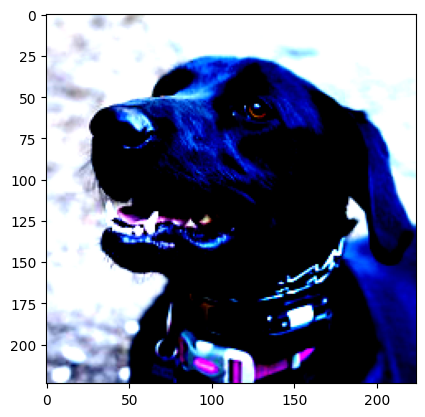

In [8]:
pil_image = Image.open(IMAGE_FILENAME)
processed_image = process_image(np.array(pil_image))
print(f"Processed image shape: {processed_image.shape}")
# Processed image is in (C,H,W) format, convert to (H,W,C) to show the image
plt.imshow(np.transpose(processed_image, (1, 2, 0)))

To decode the labels predicted by the model to names of classes, we need to have a mapping between them. The model config contains information about `class_id_map_file`, which stores such mapping. The code below shows how to parse the mapping into a dictionary to use with the OpenVINO model.

In [9]:
class_id_map_file = classifier.get_config()["PostProcess"]["Topk"]["class_id_map_file"]
class_id_map = {}
with open(class_id_map_file, "r") as fin:
    lines = fin.readlines()
    for line in lines:
        partition = line.split("\n")[0].partition(" ")
        class_id_map[int(partition[0])] = str(partition[-1])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Convert the Model to OpenVINO IR Format
[back to top ⬆️](#Table-of-contents:)

Call the OpenVINO Model Conversion API to convert the PaddlePaddle model to OpenVINO IR, with FP32 precision. `ov.convert_model` function accept path to PaddlePaddle model and returns OpenVINO Model class instance which represents this model. Obtained model is ready to use and loading on device using `ov.compile_model` or can be saved on disk using `ov.save_model` function.
See the [Model Conversion Guide](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html) for more information about the Model Conversion API.

In [10]:
model_xml = Path(MODEL_NAME).with_suffix(".xml")
if not model_xml.exists():
    ov_model = ov.convert_model("model/MobileNetV3_large_x1_0_infer/inference.pdmodel")
    ov.save_model(ov_model, str(model_xml))
else:
    print(f"{model_xml} already exists.")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [11]:
core = ov.Core()
device = device_widget()

device

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Show Inference on OpenVINO Model
[back to top ⬆️](#Table-of-contents:)

Load the IR model, get model information, load the image, do inference, convert the inference to a meaningful result, and show the output. See the [OpenVINO Runtime API Notebook](../openvino-api/openvino-api.ipynb) for more information.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Labrador retriever, 0.74909
German short-haired pointer, 0.02368
Great Dane, 0.01873


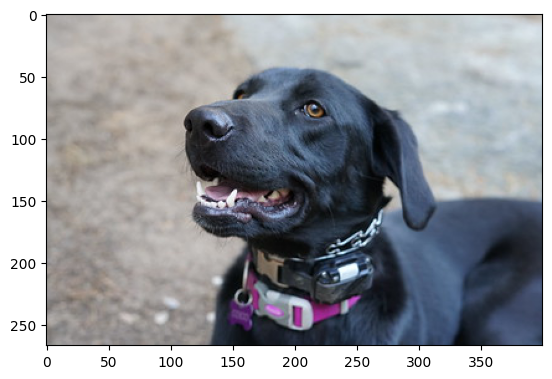

In [12]:
# Load OpenVINO Runtime and OpenVINO IR model
core = ov.Core()
model = core.read_model(model_xml)
compiled_model = core.compile_model(model=model, device_name=device.value)

# Get model output
output_layer = compiled_model.output(0)

# Read, show, and preprocess input image
# See the "Show Inference on PaddlePaddle Model" section for source of process_image
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
input_image = process_image(np.array(image))[None,]

# Do inference
ov_result = compiled_model([input_image])[output_layer][0]

# find the top three values
top_indices = np.argsort(ov_result)[-3:][::-1]
top_scores = ov_result[top_indices]

# Convert the inference results to class names, using the same labels as the PaddlePaddle classifier
for index, softmax_probability in zip(top_indices, top_scores):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")

## Timing and Comparison
[back to top ⬆️](#Table-of-contents:)

Measure the time it takes to do inference on fifty images and compare the result. The timing information gives an indication of performance. For a fair comparison, we include the time it takes to process the image. For more accurate benchmarking, use the [OpenVINO benchmark tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html). Note that many optimizations are possible to improve the performance.

In [13]:
num_images = 50

image = Image.open(fp=IMAGE_FILENAME)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
import openvino.properties as props


# Show device information
core = ov.Core()
devices = core.available_devices

for device_name in devices:
    device_full_name = core.get_property(device_name, props.device.full_name)
    print(f"{device_name}: {device_full_name}")

CPU:            Intel(R) Xeon(R) CPU @ 2.20GHz


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PaddlePaddle model on CPU: 0.1742 seconds per image, FPS: 5.74

PaddlePaddle result:
Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


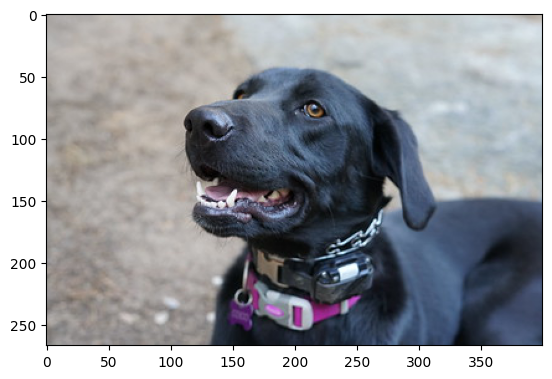

In [15]:
# Show inference speed on PaddlePaddle model
start = time.perf_counter()
for _ in range(num_images):
    result = next(classifier.predict(np.array(image)))
end = time.perf_counter()
time_ir = end - start
print(f"PaddlePaddle model on CPU: {time_ir/num_images:.4f} " f"seconds per image, FPS: {num_images/time_ir:.2f}\n")
print("PaddlePaddle result:")
class_names = result[0]["label_names"]
scores = result[0]["scores"]
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")
plt.imshow(image);

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [16]:
device

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OpenVINO IR model in OpenVINO Runtime (AUTO): 0.0224 seconds per image, FPS: 44.64

OpenVINO result:
Labrador retriever, 0.74909
German short-haired pointer, 0.02368
Great Dane, 0.01873
Rottweiler, 0.01448
flat-coated retriever, 0.01153


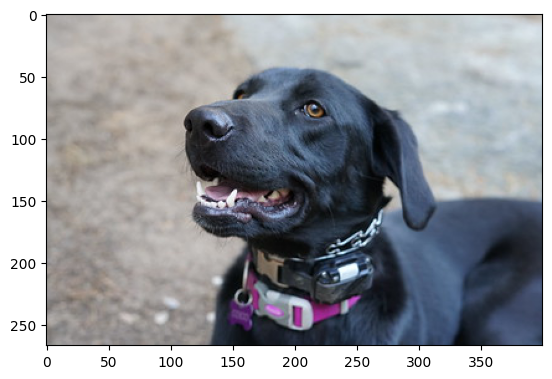

In [17]:
# Show inference speed on OpenVINO IR model
compiled_model = core.compile_model(model=model, device_name=device.value)
output_layer = compiled_model.output(0)


start = time.perf_counter()
input_image = process_image(np.array(image))[None,]
for _ in range(num_images):
    ie_result = compiled_model([input_image])[output_layer][0]
    top_indices = np.argsort(ie_result)[-5:][::-1]
    top_softmax = ie_result[top_indices]

end = time.perf_counter()
time_ir = end - start

print(f"OpenVINO IR model in OpenVINO Runtime ({device.value}): {time_ir/num_images:.4f} " f"seconds per image, FPS: {num_images/time_ir:.2f}")
print()
print("OpenVINO result:")
for index, softmax_probability in zip(top_indices, top_softmax):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")
plt.imshow(image);

## References
[back to top ⬆️](#Table-of-contents:)


* [PaddleClas](https://github.com/PaddlePaddle/PaddleClas)
* [OpenVINO PaddlePaddle support](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-paddle.html)